In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
#import mpl_finance as fin
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
ril = web.get_data_yahoo('RELIANCE.NS', '2015-01-01', '2019-12-31')
df = ril.drop(['Open', 'High', 'Low', 'Close'], axis=1)
df.head()

,Volume,Adj Close
Date,,
2015-01-01,1354878.0,415.367096
2015-01-02,3351654.0,414.267700
2015-01-05,4619182.0,409.729980
2015-01-06,8516086.0,391.134613
2015-01-07,9472630.0,399.648712


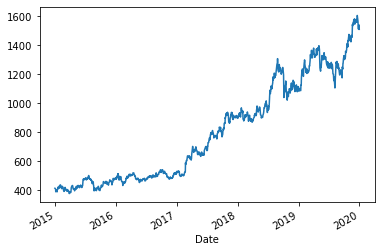

In [3]:
df["Adj Close"].plot()

In [4]:
def BollingerBands(df):
    window = 20
    std = 2
   
    df['BB_mid']   = df['Adj Close'].rolling(window).mean()
    df['BB_upper'] = df['Adj Close'].rolling(window).mean() + (df['BB_mid'].rolling(window).std() * std)
    df['BB_lower'] = df['Adj Close'].rolling(window).mean() - (df['BB_mid'].rolling(window).std() * std)
    
    return df

In [5]:
def RSI(data, time_window):
    diff = data.diff(1).dropna()        
    gain = 0 * diff
    loss = 0 * diff
    
    gain[diff > 0] = diff[ diff>0 ]
    loss[diff < 0] = diff[ diff < 0 ]
    
    avg_gain   = gain.ewm(com=time_window-1 , min_periods=time_window).mean()
    avg_loss = loss.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(avg_gain/avg_loss)
    rsi = 100 - 100/(1+rs)
    return rsi

In [6]:
df['RSI'] = RSI(df['Adj Close'], 14)
df = BollingerBands(df)
df = df.dropna()
df['Position'] = 0
df

,Volume,Adj Close,RSI,BB_mid,BB_upper,BB_lower,Position
Date,,,,,,,
2015-02-26,9810676.0,393.894684,35.074166,419.072137,429.304500,408.839775,0
2015-02-27,8530440.0,400.233490,40.821010,417.344754,426.612929,408.076579,0
2015-03-02,6665262.0,404.303436,44.234090,416.151843,424.490579,407.813108,0
2015-03-03,9434508.0,421.401825,55.774114,415.982263,423.374326,408.590200,0
2015-03-04,6617962.0,415.343658,51.692463,414.818590,421.632695,408.004484,0
...,...,...,...,...,...,...,...
2019-12-24,8251144.0,1540.665039,49.912228,1564.388464,1620.640199,1508.136730,0
2019-12-26,13605737.0,1509.731201,43.530316,1561.676147,1614.537154,1508.815141,0
2019-12-27,8081591.0,1536.580322,49.558826,1559.785742,1608.681082,1510.890402,0


In [10]:
# Strategy - buy the stock if either the RSI crosses 30 from below or the stock price crosses the lower bollinger band from below.
#            sell the stock if either the RSI crosses 70 from above or the stock price crosses the upper bollinger band from above.

def trading_strategy(df):
    
    #Position = 1 implies that stock is being held
    #Position = 0 implies that no stock is being held
    
    average_volume = df['Volume'].rolling(3).mean()
    for row in range(1, len(df)):
        if(df['Position'].iloc[row-1]==0):
            if((df['RSI'].iloc[row-1] < 30 and df['RSI'].iloc[row] > 30) or (df['Adj Close'].iloc[row] > df['BB_lower'].iloc[row]) and 
            (df['Adj Close'].iloc[row-1] < df['BB_lower'].iloc[row-1])):
                df['Position'].iloc[row] = 1
            else:
                df['Position'].iloc[row] = 0
            
            
        elif (df['Position'].iloc[row-1]==1):
            if ((df['RSI'].iloc[row-1] > 70 and df['RSI'].iloc[row] < 70) or (df['Adj Close'].iloc[row-1] > df['BB_upper'].iloc[row-1]) and 
            (df['Adj Close'].iloc[row] < df['BB_upper'].iloc[row])) :
                df['Position'].iloc[row] = 0
            else:
                df['Position'].iloc[row] = 1
                
    return df

In [11]:
trading_strategy(df)

,Volume,Adj Close,RSI,BB_mid,BB_upper,BB_lower,Position,Market Return,Strategy Return
Date,,,,,,,,,
2015-02-26,9810676.0,393.894684,35.074166,419.072137,429.304500,408.839775,0,NaN,NaN
2015-02-27,8530440.0,400.233490,40.821010,417.344754,426.612929,408.076579,0,0.015965,0.000000
2015-03-02,6665262.0,404.303436,44.234090,416.151843,424.490579,407.813108,0,0.010118,0.000000
2015-03-03,9434508.0,421.401825,55.774114,415.982263,423.374326,408.590200,1,0.041421,0.041421
2015-03-04,6617962.0,415.343658,51.692463,414.818590,421.632695,408.004484,1,-0.014481,-0.014481
...,...,...,...,...,...,...,...,...,...
2019-12-24,8251144.0,1540.665039,49.912228,1564.388464,1620.640199,1508.136730,0,-0.016005,-0.000000
2019-12-26,13605737.0,1509.731201,43.530316,1561.676147,1614.537154,1508.815141,0,-0.020283,-0.000000
2019-12-27,8081591.0,1536.580322,49.558826,1559.785742,1608.681082,1510.890402,0,0.017628,0.000000


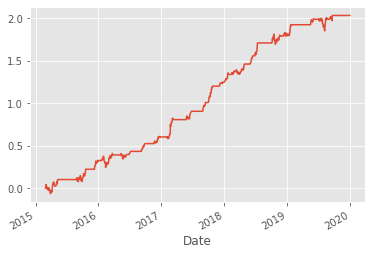

In [12]:
df['Market Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df['Strategy Return'] = df['Market Return'] * df['Position']
#Plot the strategy returns
plt.style.use('ggplot')
df['Strategy Return'].cumsum().plot()